# Lecture 11 - Dimension Reduction and Clustering

```{contents}
:local:
:depth: 1
```
## Learning goals

- Understand **unsupervised learning** vs **supervised learning** in chemistry.
- Explain the intuition and math of **PCA** and read **loadings**, **scores**, and **explained variance**.
- Use **t-SNE** and **UMAP** to embed high dimensional chemical features to 2D for visualization.
- Compare distance metrics and why **standardization** matters.
- Perform **K-means** clustering, choose **K** using elbow and silhouette, and interpret clusters.
- Try **Agglomerative** and **DBSCAN** for shapes that K-means misses.

---

## 1. Setup and data

We will reuse the C–H oxidation dataset and compute a small set of descriptors.

In [1]:



# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples, pairwise_distances

try:
  import umap.umap_ as umap
except:
  %pip install umap-learn
  import umap.umap_ as umap

# Utils
import warnings
warnings.filterwarnings("ignore")


try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors
    RD = True
except Exception:
    try:
      %pip install rdkit
      from rdkit import Chem
      from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors
      RD = True
    except:
      RD = False
      Chem = None


In [2]:
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv"
df_raw = pd.read_csv(url)
df_raw.head(3)

,Compound Name,CAS,SMILES,Solubility_mol_per_L,pKa,Toxicity,Melting Point,Reactivity,Oxidation Site
0,"3,4-dihydro-1H-isochromene",493-05-0,c1ccc2c(c1)CCOC2,0.103906,5.80,non_toxic,65.8,1,"8,10"
1,9H-fluorene,86-73-7,c1ccc2c(c1)Cc1ccccc1-2,0.010460,5.82,toxic,90.0,1,7
2,"1,2,3,4-tetrahydronaphthalene",119-64-2,c1ccc2c(c1)CCCC2,0.020589,5.74,toxic,69.4,1,"7,10"


We compute four quick descriptors for everyone. If RDKit is available, we will also compute a binary Morgan fingerprint.

In [3]:
def calc_descriptors(smiles: str):
    if not RD or smiles is None:
        return pd.Series({"MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "NumRings": np.nan})
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        return pd.Series({"MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "NumRings": np.nan})
    return pd.Series({
        "MolWt": Descriptors.MolWt(m),
        "LogP": Crippen.MolLogP(m),
        "TPSA": rdMolDescriptors.CalcTPSA(m),
        "NumRings": rdMolDescriptors.CalcNumRings(m),
    })

desc = df_raw["SMILES"].apply(calc_descriptors)
df = pd.concat([df_raw, desc], axis=1)

print("Rows x Cols:", df.shape)
df[["Compound Name","SMILES","MolWt","LogP","TPSA","NumRings","Toxicity"]].head()

Rows x Cols: (575, 13)


,Compound Name,SMILES,MolWt,LogP,TPSA,NumRings,Toxicity
0,"3,4-dihydro-1H-isochromene",c1ccc2c(c1)CCOC2,134.178,1.7593,9.23,2.0,non_toxic
1,9H-fluorene,c1ccc2c(c1)Cc1ccccc1-2,166.223,3.2578,0.00,3.0,toxic
2,"1,2,3,4-tetrahydronaphthalene",c1ccc2c(c1)CCCC2,132.206,2.5654,0.00,2.0,toxic
3,ethylbenzene,CCc1ccccc1,106.168,2.2490,0.00,1.0,non_toxic
4,cyclohexene,C1=CCCCC1,82.146,2.1166,0.00,1.0,non_toxic


Now we build a 1024-bit Morgan fingerprint ($r=2$). We keep both a **small descriptor table** and a **high dimensional fingerprint** table.

In [4]:
if RD:
    def morgan_bits(smiles, n_bits=1024, radius=2):
        m = Chem.MolFromSmiles(smiles)
        if m is None:
            return np.zeros(n_bits, dtype=np.int8)
        bv = rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius=radius, nBits=n_bits)
        arr = np.zeros((n_bits,), dtype=np.int8)
        _ = Chem.DataStructs.ConvertToNumpyArray(bv, arr)  # fills arr in place
        return arr

    X_fp = np.vstack(df["SMILES"].apply(morgan_bits).to_numpy())
    print("Fingerprint shape:", X_fp.shape)
else:
    X_fp = None
    print("RDKit not available. Fingerprints will be skipped.")

# Small numeric descriptors
X_small = df[["MolWt","LogP","TPSA","NumRings"]].astype(float).to_numpy()
mask_small = np.isfinite(X_small).all(axis=1)
X_small = X_small[mask_small]
labels_all = df.loc[mask_small, "Toxicity"].str.lower().map({"toxic":1, "non_toxic":0})
y_toxic = labels_all.fillna(-1).to_numpy()  # -1 if missing

print("Small descriptor matrix:", X_small.shape, "  Toxicity labels:", np.unique(y_toxic, return_counts=True))

Fingerprint shape: (575, 1024)
Small descriptor matrix: (575, 4)   Toxicity labels: (array([0, 1], dtype=int64), array([101, 474], dtype=int64))


```{admonition} Data choices
- **X_small** uses 4 descriptors. Good for first PCA stories.
- **X_fp** has 1024 bits. Good for t-SNE or UMAP since it is very high dimensional.
```


```{admonition} ⏰ Exercise 1
1. How many rows were dropped because of missing descriptor values? Use `mask_small.sum()` and `len(mask_small)` to compute it.
2. If RDKit is available, check the fraction of 1-bits in the fingerprints for the first 5 molecules.
```

---

## 2. Supervised vs unsupervised

In Lectures 6 to 8 we learned supervised models that map $x \to y$ with labeled targets. Today we switch to **unsupervised learning**.

- **Dimension reduction**: summarize high dimensional $x \in \mathbb{R}^p$ to a few coordinates $z \in \mathbb{R}^k$ with $k \ll p$. You do not use $y$ during the fit.
- **Clustering**: group samples into clusters based on a similarity or distance rule. Again no labels during the fit.

We will color plots using toxicity when available. That is only to **interpret** the embedding or clusters. It is not used in the algorithms.

```{admonition} Key idea
Unsupervised learning looks for structure that is already present in $X$. Labels are for *evaluation* and interpretation only, not for fitting.
```

```{admonition} ⏰ Exercise 2
State whether each task is supervised or unsupervised:
- Predict melting point from descriptors.
- Group molecules by scaffold similarity.
- Map 1024-bit fingerprints to 2D for plotting.
- Predict toxicity from descriptors.
```


---

## 3. Standardization and distance

PCA and K-means are sensitive to scale. Always check the mean and standard deviation of features.

In [5]:
scaler = StandardScaler()
Xs = scaler.fit_transform(X_small)

print("Means (should be ~0):", np.round(Xs.mean(axis=0), 3))
print("Stds  (should be ~1):", np.round(Xs.std(axis=0), 3))

Means (should be ~0): [ 0.  0.  0. -0.]
Stds  (should be ~1): [1. 1. 1. 1.]


We also pick a distance. Two common choices:
- **Euclidean** on standardized features.
- **Cosine** which compares angles and ignores magnitude.

Below we compute both between the first 5 rows.

In [6]:
sub = Xs[:5]
D_euc = pairwise_distances(sub, metric="euclidean")
D_cos = pairwise_distances(sub, metric="cosine")

print("Euclidean distances (5x5):\n", np.round(D_euc, 3))
print("\nCosine distances (5x5):\n", np.round(D_cos, 3))

Euclidean distances (5x5):
 [[0.    1.207 0.564 0.856 0.958]
 [1.207 0.    0.876 1.624 1.772]
 [0.564 0.876 0.    0.761 0.91 ]
 [0.856 1.624 0.761 0.    0.271]
 [0.958 1.772 0.91  0.271 0.   ]]

Cosine distances (5x5):
 [[0.    0.372 0.073 0.09  0.075]
 [0.372 0.    0.186 0.444 0.443]
 [0.073 0.186 0.    0.068 0.068]
 [0.09  0.444 0.068 0.    0.004]
 [0.075 0.443 0.068 0.004 0.   ]]


```{admonition} Tip
For sparse fingerprints, cosine distance or Jaccard often makes more sense than raw Euclidean. For dense scaled descriptors, Euclidean is fine.
```


---

## 4. PCA by hand: step by step

PCA finds orthogonal directions that capture maximum variance. We implement the steps on the standardized matrix.

Mathematical pieces:

- Centered data $\tilde X$ is already produced by `StandardScaler`.
- Covariance $S = \frac{1}{n-1}\tilde X^\top \tilde X$.
- Either eigen-decompose $S$, or compute SVD of $\tilde X = U \Sigma V^\top$.
- The top $k$ columns of $V$ are the principal directions. Scores are $Z = \tilde X V_k$.

### 4.1 Centering and covariance

In [7]:
n, p = Xs.shape
Xc = Xs  # already standardized
S = (Xc.T @ Xc) / (n - 1)

print("Xc shape:", Xc.shape)
print("Covariance shape:", S.shape)

Xc shape: (575, 4)
Covariance shape: (4, 4)


### 4.2 SVD and explained variance

In [8]:
U, Sig, VT = np.linalg.svd(Xc, full_matrices=False)  # Xc = U * diag(Sig) * VT
eigvals = (Sig ** 2) / (n - 1)
evr = eigvals / eigvals.sum()

print("Singular values:", np.round(Sig, 3))
print("Explained variance ratio:", np.round(evr, 3))

Singular values: [36.978 26.855 12.106  8.052]
Explained variance ratio: [0.595 0.314 0.064 0.028]


### 4.3 Project to 2D and inspect

Scores shape: (575, 2)
First 3 rows:
 [[-1.224  0.346]
 [-0.258  1.043]
 [-1.08   0.863]]


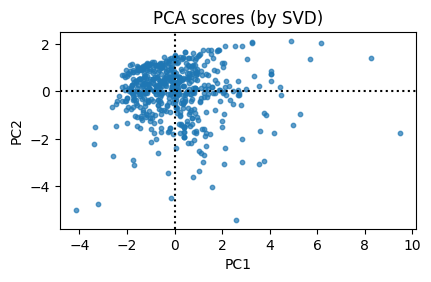

In [9]:
V2 = VT[:2].T             # p x 2
Z2 = Xc @ V2              # n x 2 scores
print("Scores shape:", Z2.shape)
print("First 3 rows:\n", np.round(Z2[:3], 3))

plt.figure(figsize=(4.6,4.2))
plt.scatter(Z2[:,0], Z2[:,1], s=10, alpha=0.7)
plt.axhline(0, ls=":", c="k"); plt.axvline(0, ls=":", c="k")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("PCA scores (by SVD)")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

```{admonition} Loadings
Columns of $V$ are **loadings**. They tell how each original feature contributes to each PC. Large magnitude means strong contribution.
```

```{admonition} ⏰ Exercise 4
Print the 4x2 loading matrix `V2` with 3 decimals. Which descriptor dominates PC1?
```


---

## 5. PCA with scikit-learn and interpretation

Now we use `sklearn.decomposition.PCA` and compare to the by-hand result.

### 5.1 Fit PCA and compare EVR

In [10]:
pca = PCA(n_components=4, random_state=0)
Z = pca.fit_transform(Xs)

print("Explained variance ratio:", np.round(pca.explained_variance_ratio_, 3))
print("Cumulative:", np.round(pca.explained_variance_ratio_.cumsum(), 3))
print("Components shape:", pca.components_.shape)  # 4 x 4 (each row is a PC)

Explained variance ratio: [0.595 0.314 0.064 0.028]
Cumulative: [0.595 0.908 0.972 1.   ]
Components shape: (4, 4)


### 5.2 Scree plot

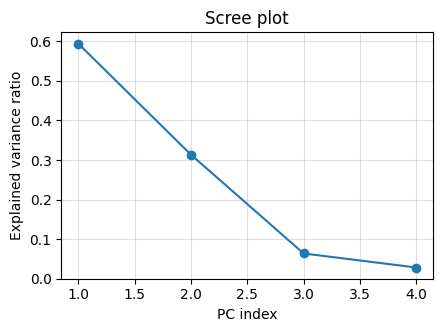

In [11]:
plt.figure(figsize=(4.8,3.2))
plt.plot(np.arange(1, p+1), pca.explained_variance_ratio_, marker="o")
plt.xlabel("PC index"); plt.ylabel("Explained variance ratio")
plt.title("Scree plot")
plt.grid(True, alpha=0.4)
plt.show()

### 5.3 Biplot: scores and loadings

We plot PC1 vs PC2 and overlay loading vectors. For color we use toxicity when known. This color is for **reading** the map only.

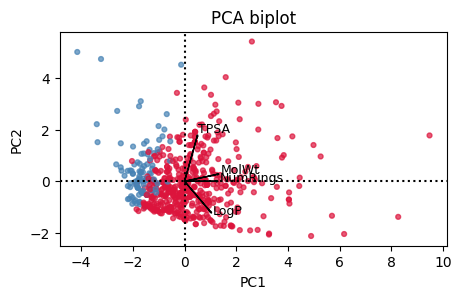

In [12]:
scores = Z[:, :2]
loads = pca.components_[:2, :].T  # shape 4x2
cols = ["MolWt","LogP","TPSA","NumRings"]

plt.figure(figsize=(5,4.6))
c = np.where(y_toxic[:len(scores)]==1, "crimson",
    np.where(y_toxic[:len(scores)]==0, "steelblue", "gray"))
plt.scatter(scores[:,0], scores[:,1], s=12, alpha=0.7, c=c)
plt.axhline(0, ls=":", c="k"); plt.axvline(0, ls=":", c="k")

for i, name in enumerate(cols):
    x, y = loads[i,0]*2.2, loads[i,1]*2.2
    plt.arrow(0, 0, x, y, head_width=0.05, length_includes_head=True)
    plt.text(x*1.05, y*1.05, name, fontsize=9)

plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("PCA biplot")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

```{admonition} Reading a biplot
- Points near each other have similar standardized descriptors.
- A loading arrow points in the direction of increase of that feature.
- The projection of a point onto an arrow relates to that feature value.
```

```{admonition} ⏰ Exercise 5
Set `PCA(n_components=2, whiten=True)` and replot the biplot. How do the axes scale and the scatter change?
```

---

## 6. Nonlinear embeddings: t-SNE and UMAP

Linear PCA often works, but some manifolds curve. t-SNE and UMAP aim to keep local neighborhoods together in 2D.

We will use 1024-bit fingerprints as well.

### 6.1 Prepare features for embedding

In [13]:
if X_fp is not None:
    X_embed = X_fp.astype(float)
    feature_kind = "Morgan-1024"
else:
    X_embed = Xs
    feature_kind = "4-desc (scaled)"

print("Embedding on:", feature_kind, "| shape:", X_embed.shape)

Embedding on: Morgan-1024 | shape: (575, 1024)


### 6.2 t-SNE with two perplexities

Perplexity sets the effective neighbor count. Small values highlight very local neighborhoods. Larger values make broader groups.

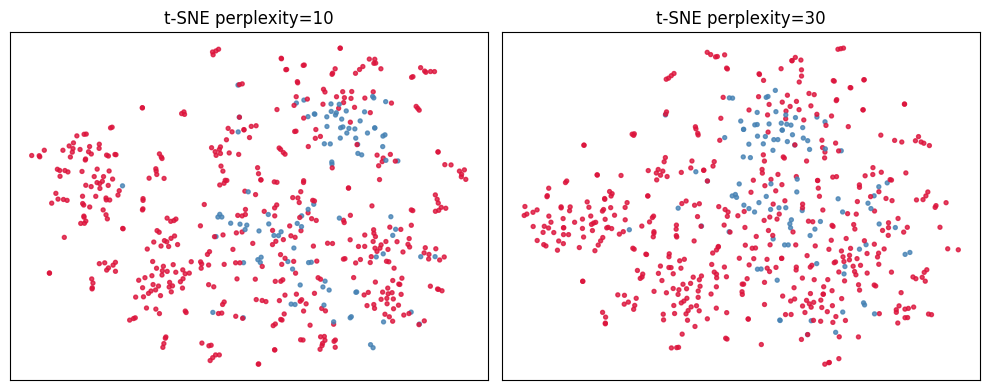

In [14]:
perps = [10, 30]
embeds = []
for perp in perps:
    tsne = TSNE(n_components=2, perplexity=perp, init="random", learning_rate="auto", random_state=0)
    Z_tsne = tsne.fit_transform(X_embed)
    embeds.append((perp, Z_tsne))

# Plot
fig, axes = plt.subplots(1, len(perps), figsize=(10,4), sharex=False, sharey=False)
for ax, (perp, Zt) in zip(axes, embeds):
    c = np.where(y_toxic[:len(Zt)]==1, "crimson",
        np.where(y_toxic[:len(Zt)]==0, "steelblue", "gray"))
    ax.scatter(Zt[:,0], Zt[:,1], s=8, c=c, alpha=0.8)
    ax.set_title(f"t-SNE perplexity={perp}")
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.show()

### 6.3 UMAP

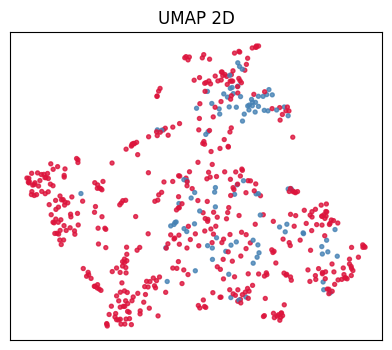

In [15]:
try:
    import umap.umap_ as umap
    um = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=0)
    Z_umap = um.fit_transform(X_embed)
    plt.figure(figsize=(4.8,4.0))
    c = np.where(y_toxic[:len(Z_umap)]==1, "crimson",
        np.where(y_toxic[:len(Z_umap)]==0, "steelblue", "gray"))
    plt.scatter(Z_umap[:,0], Z_umap[:,1], s=8, c=c, alpha=0.8)
    plt.xticks([]); plt.yticks([])
    plt.title("UMAP 2D")
    plt.show()
except Exception as e:
    print("UMAP is not installed in this environment. Skipping UMAP demo.")

```{admonition} Practical notes
- t-SNE preserves local neighborhoods but does not preserve global distances or cluster sizes.
- UMAP often runs faster on large sets and can preserve more of the global shape.
- Random seeds matter. Always record `random_state` for reproducibility.
```

```{admonition} ⏰ Exercise 6
1. Try t-SNE with `perplexity=50`. Compare the layout to 10 and 30.
2. For UMAP, change `n_neighbors` to 5 and 30. What changes in the map?
```


---

## 7. Clustering with K-means

K-means partitions points into K clusters by minimizing within-cluster squared distances. It works best when clusters are roughly spherical in the chosen space.

Objective:
$$
\min_{\{\mathcal{C}_k\}, \{\mu_k\}} \sum_{k=1}^{K} \sum_{x_i \in \mathcal{C}_k} \lVert x_i - \mu_k \rVert^2.
$$

We will cluster PCA scores rather than raw descriptors. This reduces noise and helps K-means.

### 7.1 Build PCA features for clustering

In [16]:
pca10 = PCA(n_components=min(10, Xs.shape[1]), random_state=0).fit(Xs)
Z10 = pca10.transform(Xs)
print("Z10 shape:", Z10.shape, "  EVR cum:", np.round(pca10.explained_variance_ratio_.cumsum()[-1], 3))

Z10 shape: (575, 4)   EVR cum: 1.0


### 7.2 Choose K: elbow and silhouette

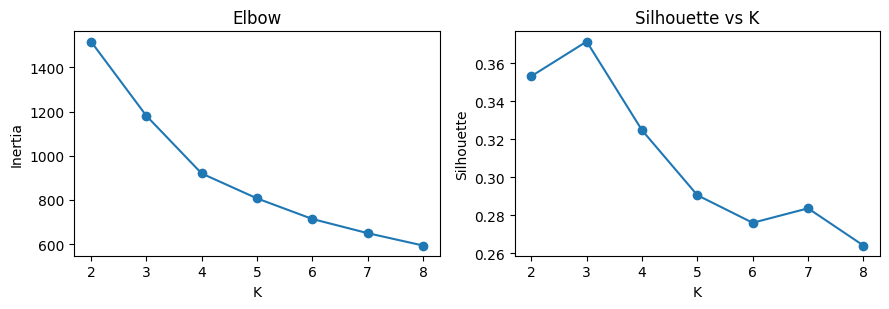

In [17]:
Ks = range(2, 9)
inertia, sil = [], []
for K in Ks:
    km = KMeans(n_clusters=K, n_init=20, random_state=0).fit(Z10)
    inertia.append(km.inertia_)
    sil.append(silhouette_score(Z10, km.labels_))

fig, ax = plt.subplots(1,2, figsize=(9,3.2))
ax[0].plot(list(Ks), inertia, marker="o"); ax[0].set_xlabel("K"); ax[0].set_ylabel("Inertia"); ax[0].set_title("Elbow")
ax[1].plot(list(Ks), sil, marker="o"); ax[1].set_xlabel("K"); ax[1].set_ylabel("Silhouette"); ax[1].set_title("Silhouette vs K")
plt.tight_layout(); plt.show()

### 7.3 Fit a K and visualize on PC1–PC2

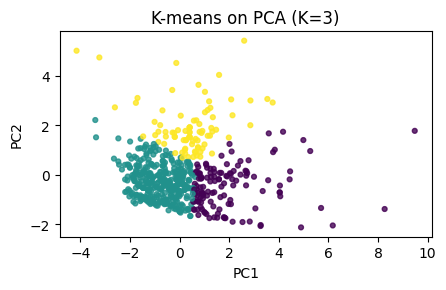

In [18]:
K_best = 3
km = KMeans(n_clusters=K_best, n_init=50, random_state=0).fit(Z10)
labs = km.labels_
sc2 = Z10[:, :2]

plt.figure(figsize=(4.8,4.4))
plt.scatter(sc2[:,0], sc2[:,1], s=12, c=labs, alpha=0.8)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title(f"K-means on PCA (K={K_best})")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

### 7.4 Interpret clusters with loadings

We can see which original descriptors drive each cluster by comparing cluster means in the original standardized space.

In [19]:
df_feat = pd.DataFrame(Xs, columns=["MolWt","LogP","TPSA","NumRings"])
df_feat["cluster"] = labs
means = df_feat.groupby("cluster").mean()
means

,MolWt,LogP,TPSA,NumRings
cluster,,,,
0,1.134097,1.121858,-0.013927,1.261552
1,-0.509381,-0.206491,-0.406939,-0.483403
2,0.480882,-0.794348,1.758678,0.179508


```{admonition} Reading cluster means
Large positive mean for a descriptor means that cluster has higher than average values for that feature in standardized units.
```

```{admonition} ⏰ Exercise 7
1. Compute the silhouette score for `K=2,3,4` and report which is largest.
2. Change the space for K-means to the **t-SNE** coordinates and try `K=3`. Does the silhouette improve or get worse? Why might that happen?
```

---

## 8. Beyond K-means: Agglomerative and DBSCAN

Some clusters are not spherical. Two alternatives:

- **Agglomerative (hierarchical)**: start with each point as a cluster, then merge nearest clusters until K remains. Linkage can be `ward`, `average`, or `complete`.
- **DBSCAN**: density based. Finds core points with at least `min_samples` neighbors within `eps`, then builds clusters of connected dense regions. Good for outliers.

We use the PCA 10D space again.

### 8.1 Agglomerative

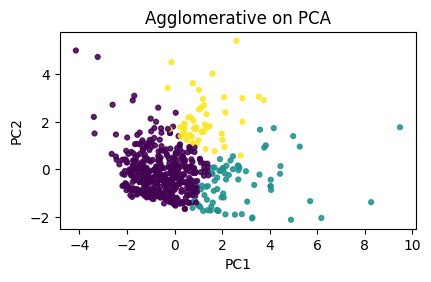

Silhouette (agg): 0.387


In [20]:
agg = AgglomerativeClustering(n_clusters=3, linkage="ward")
labs_agg = agg.fit_predict(Z10)

plt.figure(figsize=(4.6,4.2))
plt.scatter(sc2[:,0], sc2[:,1], s=12, c=labs_agg, alpha=0.85)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("Agglomerative on PCA")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

print("Silhouette (agg):", round(silhouette_score(Z10, labs_agg), 3))

### 8.2 DBSCAN

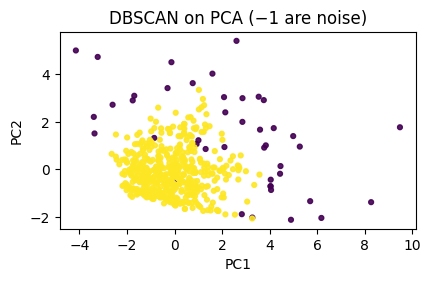

{-1: 43, 0: 532}

In [21]:
db = DBSCAN(eps=0.9, min_samples=6)  # eps is sensitive to scale
labs_db = db.fit_predict(Z10)

plt.figure(figsize=(4.6,4.2))
plt.scatter(sc2[:,0], sc2[:,1], s=12, c=labs_db, alpha=0.9)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("DBSCAN on PCA (−1 are noise)")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

vals, cnts = np.unique(labs_db, return_counts=True)
dict(zip(vals, cnts))

```{admonition} Tips for DBSCAN
- Scale matters. Tune `eps` after standardization or PCA.
- `-1` labels are noise or outliers.
- You can grid search `eps` on a small set to find stable clusters.
```

---

## 9. Glossary

{glossary}
dimension reduction
  Map $p$-dimensional features to a few coordinates that keep the most structure for your task.

PCA
  Linear method that finds orthogonal directions of maximum variance.

loading
  The weight of each original feature for a principal component.

score
  The coordinates of each sample in PC space.

scree plot
  Bar or line plot of explained variance ratio per PC.

t-SNE
  Nonlinear embedding that preserves local neighbor relations. Uses a KL divergence objective.

UMAP
  Graph-based embedding that models fuzzy set cross entropy on a kNN graph.

K-means
  Clustering by minimizing within-cluster squared distances to centroids.

silhouette
  For a point, $s=(b-a)/\max(a,b)$ where $a$ is mean intra-cluster distance and $b$ is the smallest mean distance to another cluster.

DBSCAN
  Density-based clustering that finds core points and expands clusters. Labels noise as $-1$.


---

## 10. In-class activity with solutions

Five hands-on questions. Each can be solved with code from this lecture. Write your answers in small blocks and explain what you see.

### Q1. PCA for interpretation
- Use `X_small` scaled. Fit `PCA(n_components=4)`.
- Report the loading vector for PC1 and PC2.
- Write one sentence per PC about what chemical trend each PC seems to capture.



```python
scaler = StandardScaler()
Xs = scaler.fit_transform(X_small)
pca = PCA(n_components=4, random_state=0).fit(Xs)
loads = pd.DataFrame(pca.components_.T, index=["MolWt","LogP","TPSA","NumRings"], columns=[f"PC{i+1}" for i in range(4)])
loads.round(3)
```

**Solution**

```python
cum = pca.explained_variance_ratio_.cumsum()
print("EVR:", np.round(pca.explained_variance_ratio_,3), "  Cumulative:", np.round(cum,3))
loads
```


---

### Q2. Choose K by silhouette
- Use `Z10` from PCA on `X_small`.
- Compute silhouette for `K=2..8` and pick the best K. Plot silhouette vs K.

**Starter**

```python
Ks = range(2, 9)
scores = []
for K in Ks:
    km = KMeans(n_clusters=K, n_init=30, random_state=0).fit(Z10)
    scores.append(silhouette_score(Z10, km.labels_))
pd.DataFrame({"K": list(Ks), "silhouette": np.round(scores,3)})
```

**Solution**

```python
plt.plot(list(Ks), scores, marker="o"); plt.xlabel("K"); plt.ylabel("Silhouette"); plt.grid(True, alpha=0.4)
K_best = Ks[int(np.argmax(scores))]
print("Best K by silhouette:", K_best)
```

---

### Q3. t-SNE vs UMAP on fingerprints
- If RDKit is available, embed `X_fp` with t-SNE and UMAP.
- Use the same `random_state` and similar neighbor counts.
- Color by toxicity when available.

**Starter**

```python
if X_fp is not None:
    X_embed = X_fp.astype(float)
    tsne = TSNE(n_components=2, perplexity=30, init="random", learning_rate="auto", random_state=0)
    Zt = tsne.fit_transform(X_embed)
    try:
        import umap.umap_ as umap
        Zu = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=0).fit_transform(X_embed)
    except Exception:
        Zu = None
else:
    print("Skip. No fingerprints.")
```

**Solution**

```python
if X_fp is not None:
    plt.figure(figsize=(9,4))
    c = np.where(y_toxic[:len(Zt)]==1, "crimson", np.where(y_toxic[:len(Zt)]==0, "steelblue", "gray"))
    plt.subplot(1,2,1); plt.scatter(Zt[:,0], Zt[:,1], s=8, c=c, alpha=0.8); plt.title("t-SNE"); plt.xticks([]); plt.yticks([])
    if Zu is not None:
        plt.subplot(1,2,2); plt.scatter(Zu[:,0], Zu[:,1], s=8, c=c, alpha=0.8); plt.title("UMAP"); plt.xticks([]); plt.yticks([])
    plt.tight_layout(); plt.show()
```

Comment on whether groups align between methods.

---

### Q4. DBSCAN to find outliers
- Work in PCA 10D space.
- Tune `eps` to find at least one noise point.
- Print cluster counts.

**Starter**

```python
for eps in [0.6, 0.8, 1.0]:
    db = DBSCAN(eps=eps, min_samples=6).fit(Z10)
    vals, cnts = np.unique(db.labels_, return_counts=True)
    print("eps=", eps, dict(zip(vals, cnts)))
```

**Solution**

```python
eps = 0.8
db = DBSCAN(eps=eps, min_samples=6).fit(Z10)
labs = db.labels_
plt.scatter(Z10[:,0], Z10[:,1], s=12, c=labs, alpha=0.9)
plt.title(f"DBSCAN on PCA, eps={eps}")
plt.show()
```

---

### Q5. Cluster meaning in original units
- Fit K-means with `K=3` on `Z10`.
- For each cluster, compute the mean of original descriptors **before** scaling.
- Report a small table and give one sentence per cluster.

**Starter**

```python
km = KMeans(n_clusters=3, n_init=50, random_state=0).fit(Z10)
labs = km.labels_
D_orig = df.loc[mask_small, ["MolWt","LogP","TPSA","NumRings"]].reset_index(drop=True)
D_orig["cluster"] = labs
D_orig.groupby("cluster").mean().round(2)
```

**Solution**

```python
tbl = D_orig.groupby("cluster").agg(["mean","std"]).round(2)
tbl
```